# CAM vs Grad-CAM

- CAM(Class Activation Map)
  - 제약: 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 함
  - 클래스에 대한 활성화 정도를 나타낸 지도 : 분류(classfication) 를 수행하는 모델 필요
  - 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교 : 위치 정보가 기록된 데이터가 함께 있어야 함
- Grad-CAM(Gradient Class Activation Map)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


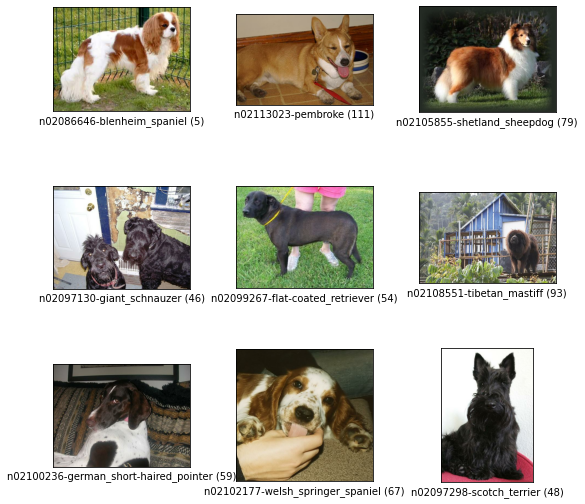

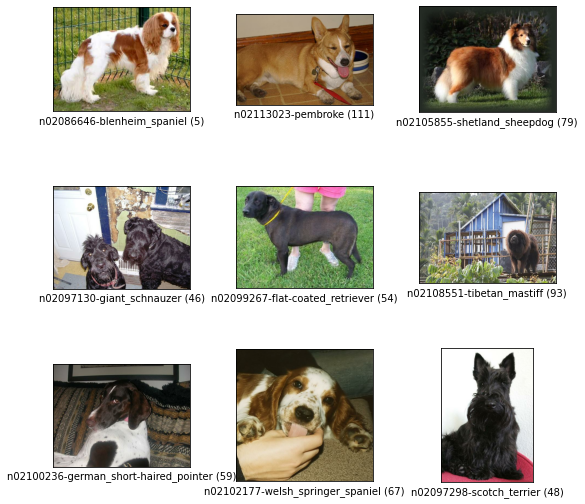

In [4]:
tfds.show_examples(ds_train, ds_info)

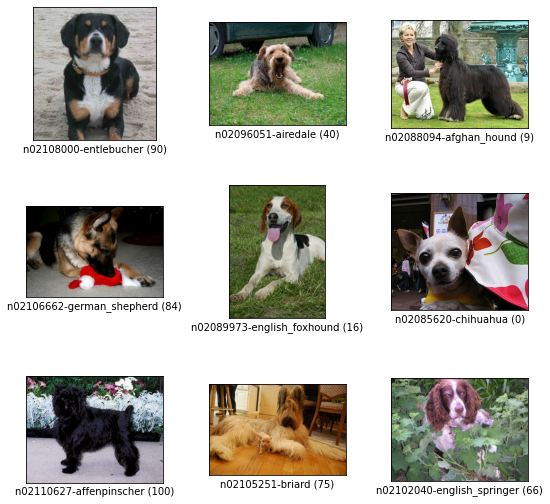

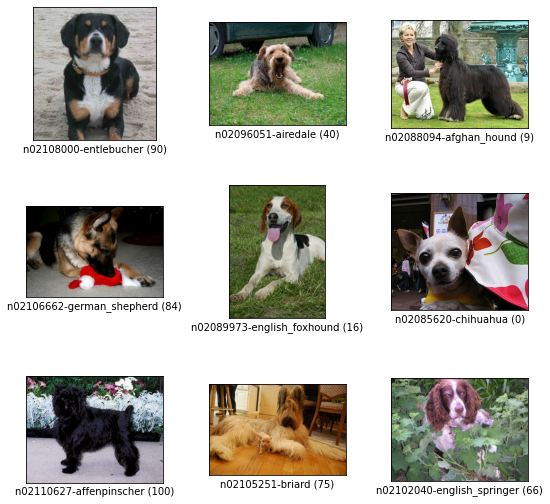

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
# base_model.summary()

x = base_model.output
preds = keras.layers.Dense(
        num_classes, 
        activation='softmax',
        name='softmax_layer',
    )(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [14]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/checkpoint/cam_model_best_model.weights.h5'
cam_model_checkpoint = ModelCheckpoint(
    cam_model_path,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)

In [16]:
EPOCH=10
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    callbacks=[cam_model_checkpoint],
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 148s 197ms/step - loss: 2.2260 - accuracy: 0.4410 - val_loss: 2.9594 - val_accuracy: 0.2771

Epoch 00001: val_loss improved from inf to 2.95941, saving model to /aiffel/aiffel/class_activation_map/checkpoint/cam_model_best_model.weights.h5
Epoch 2/10
750/750 [==============================] - 153s 204ms/step - loss: 0.6347 - accuracy: 0.8341 - val_loss: 1.1635 - val_accuracy: 0.6574

Epoch 00002: val_loss improved from 2.95941 to 1.16349, saving model to /aiffel/aiffel/class_activation_map/checkpoint/cam_model_best_model.weights.h5
Epoch 3/10
750/750 [==============================] - 153s 204ms/step - loss: 0.1704 - accuracy: 0.9758 - val_loss: 1.0467 - val_accuracy: 0.6945

Epoch 00003: val_loss improved from 1.16349 to 1.04673, saving model to /aiffel/aiffel/class_activation_map/checkpoint/cam_model_best_model.weights.h5
Epoch 4/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0546 - accuracy: 0.9967 - val_

- 학습률 시각화

In [17]:
def visualize_history(history, title):
    plt.figure(figsize=(12, 5))

    accuray_gap = [train - val for train, val in zip(history.history['accuracy'], history.history['val_accuracy'])]
    loss_gap = [train - val for train, val in zip(history.history['loss'], history.history['val_loss'])]

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(accuray_gap, label='Accuracy Gap (Train - Val)', linestyle='dashed')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(loss_gap, label='Loss Gap (Train - Val)', linestyle='dashed')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

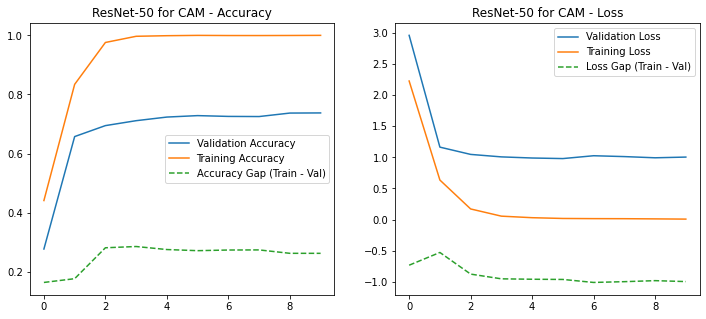

In [18]:
visualize_history(history_cam_model, "ResNet-50 for CAM")

---

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있어야 함

In [5]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data[0]

{'image': array([[[ 55,  70, 113],
        [ 59,  74, 115],
        [ 41,  56,  95],
        ...,
        [ 27,  29,  15],
        [ 48,  50,  36],
        [ 41,  44,  27]],

       [[ 35,  50,  93],
        [ 42,  57,  98],
        [ 29,  44,  83],
        ...,
        [ 43,  47,  32],
        [ 50,  53,  36],
        [ 32,  36,  19]],

       [[ 25,  40,  83],
        [ 34,  49,  90],
        [ 25,  40,  79],
        ...,
        [ 10,  17,   1],
        [ 12,  16,   0],
        [  6,  13,   0]],

       ...,

       [[123, 152,  86],
        [149, 178, 112],
        [136, 162,  97],
        ...,
        [162, 178, 131],
        [188, 201, 155],
        [166, 179, 133]],

       [[102, 131,  65],
        [ 93, 122,  56],
        [137, 164,  97],
        ...,
        [167, 186, 131],
        [155, 172, 118],
        [152, 169, 115]],

       [[138, 167, 101],
        [147, 176, 110],
        [118, 145,  78],
        ...,
        [161, 182, 123],
        [133, 151,  93],
        [159, 

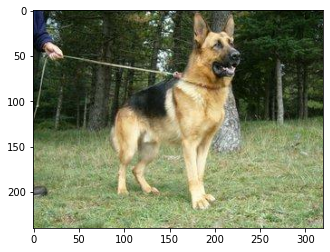

In [8]:
item = get_one(ds_test)
print(item)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [10]:
import os

num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(
        num_classes, 
        activation='softmax',
        name='softmax_layer',
    )(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/checkpoint/cam_model_best_model.weights.h5'
cam_model.load_weights(cam_model_path)

94781440/94765736 [==============================] - 0s 0us/step


## CAM 구현하기

### `generate_cam()`
- input params: `model`, `item`
- return: `cam_image` with the same size as the input image

In [6]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    
    # get the input image size
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_output_model = tf.keras.models.Model(
        [model.inputs],
        # output : conv5_block3_out and predicted label
        [model.layers[-3].output, model.output])
    # add batch dimension
    conv_output, predictions = cam_output_model(tf.expand_dims(img_tensor, 0))
    pred_idx = np.argmax(predictions)
        
    # remove batch dimension
    conv_output = conv_output[0, :, :, :]
    
    # get softmax layer's weights
    class_weights = model.layers[-1].get_weights()[0] 
    # print(class_weights.shape) # num of feature maps x num of classes
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # multiply weights of the input label and the activation values of i-th feature map
        cam_image += w * conv_output[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image, pred_idx

n02106662-german_shepherd


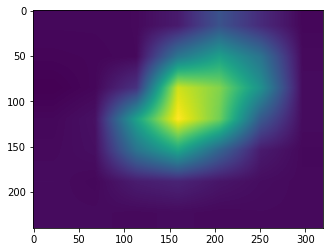

In [73]:
cam_image, pred_idx = generate_cam(cam_model, item)
print(ds_info.features['label'].int2str(pred_idx))
plt.imshow(cam_image)
plt.show()

In [87]:
def visualize_cam_on_image(cam_image, src_image, alpha=0.7):
    beta = 1.0 - alpha
    merged_image = cv2.addWeighted(cam_image.astype(np.uint8), alpha, src_image.astype(np.uint8), beta, 0.0)
    plt.imshow(merged_image)
    plt.show()
    return merged_image

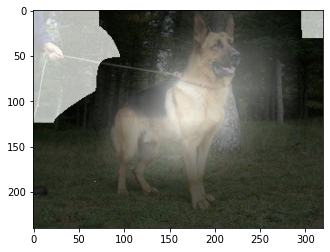

In [59]:
blended_image = visualize_cam_on_image(np.stack([cam_image*255]*3, axis=-1), item['image'])
plt.imshow(blended_image)
plt.show()

## Grad-CAM 구현하기

### `generate_grad_cam()`
- input params: `model`, `act_layer_name`, `item`
- return: `cam_image` with the same size as the input image

In [14]:
def generate_grad_cam(model, act_layer_name, item):
    item = copy.deepcopy(item)
    
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(act_layer_name).output, model.output]
    )
    
    # get gradient
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(tf.expand_dims(img_tensor, 0))
        loss = predictions[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    pred_idx = np.argmax(predictions)
    weights = np.mean(grad_val, axis=(0, 1))
    # print(weights.shape)
        
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # multiply weights of the input label and the activation values of k-th feature map
        grad_cam_image += w * output[:, :, k]
        
    # ignore negative values
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image, pred_idx

n02106662-german_shepherd


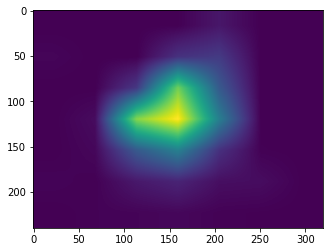

In [60]:
grad_cam_image, pred_idx = generate_grad_cam(cam_model, 'conv5_block3_out', item)
print(ds_info.features['label'].int2str(pred_idx))
plt.imshow(grad_cam_image)
plt.show()

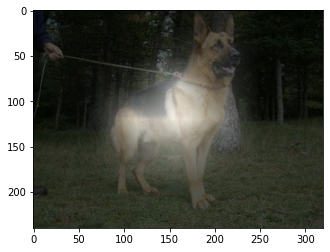

In [61]:
blended_image = visualize_cam_on_image(np.stack([grad_cam_image*255]*3, axis=-1), item['image'])
plt.imshow(blended_image)
plt.show()

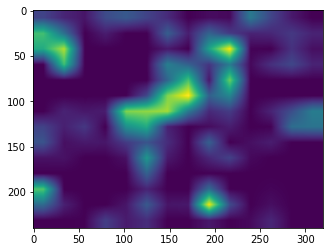

In [62]:
grad_cam_image_43, pred_idx = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_43)
plt.show()

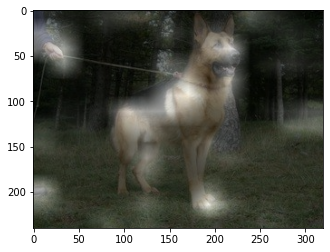

In [63]:
blended_image_43 = visualize_cam_on_image(np.stack([grad_cam_image_43*255]*3, axis=-1), item['image'])
plt.imshow(blended_image_43)
plt.show()

## Bounding box and IoU


`get_bbox()`
- 바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앰
- OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾음
- `rotated_rect` 라는 회전된 바운딩 박스를 얻음
- `boxPoints()`로 이를 꼭지점으로 바꿈
- int 자료형으로 변환

In [35]:
def minmax_to_rect(minmax, image):
    y_min = int(minmax[0] * image.shape[0])
    x_min = int(minmax[1] * image.shape[1])
    y_max = int(minmax[2] * image.shape[0])
    x_max = int(minmax[3] * image.shape[1])

    # Bounding box 네 꼭짓점 좌표 반환 (좌상, 우상, 좌하, 우하)
    rect = np.array([
        [x_min, y_min],  # 좌상
        [x_max, y_min],  # 우상
        [x_max, y_max],  # 우하
        [x_min, y_max]   # 좌하
    ])
    
    return rect

In [64]:
def visualize_bbox_on_image(rect, src_image):
    image = src_image.copy()
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    plt.imshow(image)
    plt.show()
    return image

In [76]:
def get_bbox_on_image(cam, src_image, score_thresh=0.05):
    low_indicies = cam <= score_thresh
    
    cam_image = cam.copy()
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    
    image = visualize_bbox_on_image(rect, src_image)

    return rect, image

### Original Bounding Box

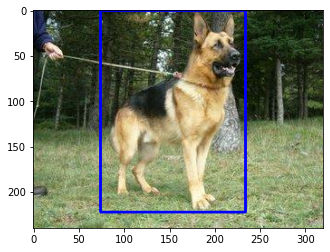

array([[[ 55,  70, 113],
        [ 59,  74, 115],
        [ 41,  56,  95],
        ...,
        [ 27,  29,  15],
        [ 48,  50,  36],
        [ 41,  44,  27]],

       [[ 35,  50,  93],
        [ 42,  57,  98],
        [ 29,  44,  83],
        ...,
        [ 43,  47,  32],
        [ 50,  53,  36],
        [ 32,  36,  19]],

       [[ 25,  40,  83],
        [ 34,  49,  90],
        [ 25,  40,  79],
        ...,
        [ 10,  17,   1],
        [ 12,  16,   0],
        [  6,  13,   0]],

       ...,

       [[123, 152,  86],
        [149, 178, 112],
        [136, 162,  97],
        ...,
        [162, 178, 131],
        [188, 201, 155],
        [166, 179, 133]],

       [[102, 131,  65],
        [ 93, 122,  56],
        [137, 164,  97],
        ...,
        [167, 186, 131],
        [155, 172, 118],
        [152, 169, 115]],

       [[138, 167, 101],
        [147, 176, 110],
        [118, 145,  78],
        ...,
        [161, 182, 123],
        [133, 151,  93],
        [159, 177, 119]]

In [72]:
org_minmax = tf.squeeze(item['objects']['bbox'])
org_rect = minmax_to_rect(org_minmax, item['image'])
visualize_bbox_on_image(org_rect, item['image'])

### CAM Bounding Box

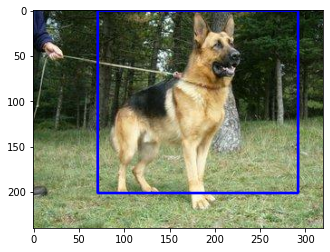

In [75]:
rect, bbox_image = get_bbox_on_image(cam_image, item['image'])

### Grad-CAM Bounding Box

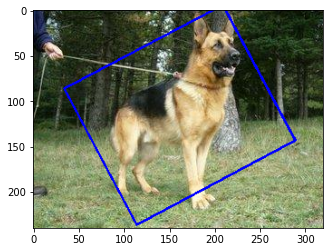

In [82]:
rect, bbox_image = get_bbox_on_image(grad_cam_image, item['image'])

**Intersection Over Union**
- IoU(Intersection over Union) 는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값
- 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구함
- 모델이 영역을 잘 찾았는지 비교하는 좋은 지표

In [34]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [36]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.025, 0.10625, 0.9833333333333333, 0.903125]

In [37]:
item['objects']['bbox']

array([[0.     , 0.23125, 0.925  , 0.73125]], dtype=float32)

In [90]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    # intersection area
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    # box A area
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    # box B area
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [91]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5755955348851673

In [96]:
def calculate_iou_and_visualize_bbox(cam_model, item, grad=False, act_layer_name=None, score_thresh=0.05, debug=False):
    # get cam image
    if grad == False:
        cam_image, pred_idx = generate_cam(cam_model, item)
    else:
        if act_layer_name == None:
            raise Exception(f'act_layer_name is None.')
        cam_image, pred_idx = generate_grad_cam(cam_model, act_layer_name, item)

    if debug == True:
        visualize_cam_on_image(np.stack([cam_image*255]*3, axis=-1), item['image'])
        org_minmax = tf.squeeze(item['objects']['bbox'])
        org_rect = minmax_to_rect(org_minmax, item['image'])
        print('Original Bouding box')
        visualize_bbox_on_image(org_rect, item['image'])

    print('Predicted Bouding box')
    rect, bbox_image = get_bbox_on_image(cam_image, item['image'], score_thresh=score_thresh)
    pred_bbox = rect_to_minmax(rect, item['image'])

    iou = get_iou(pred_bbox, item['objects']['bbox'][0])
    
    if grad == False:
        print(f'IoU : {iou} with score_thresh {score_thresh}')
    else:
        print(f'IoU : {iou} with score_thresh {score_thresh}, act_layer_name {act_layer_name}')

### threshold에 따른 bbox & iou 변화

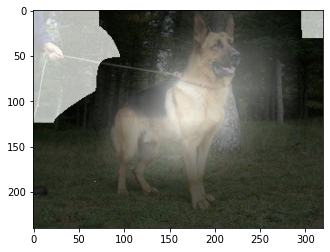

Original Bouding box


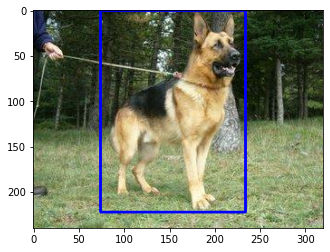

Predicted Bouding box


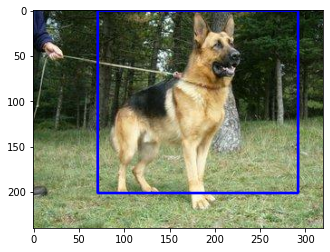

IoU : 0.6730708794686715 with score_thresh 0.05


In [97]:
calculate_iou_and_visualize_bbox(cam_model, item, debug=True)

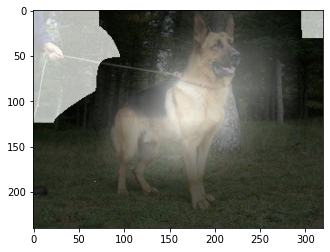

Original Bouding box


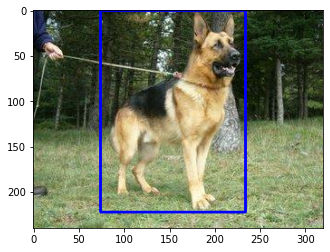

Predicted Bouding box


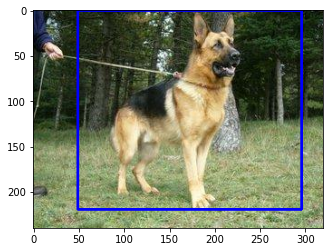

IoU : 0.6420757463595743 with score_thresh 0.01


In [98]:
calculate_iou_and_visualize_bbox(cam_model, item, score_thresh=0.01, debug=True)

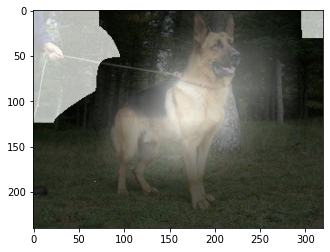

Original Bouding box


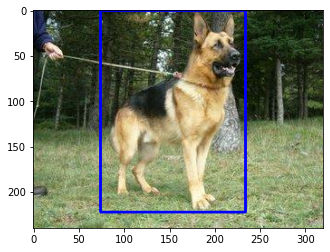

Predicted Bouding box


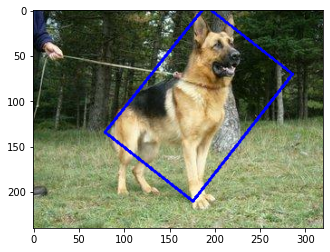

IoU : 0.6856239775843235 with score_thresh 0.3


In [99]:
calculate_iou_and_visualize_bbox(cam_model, item, score_thresh=0.3, debug=True)

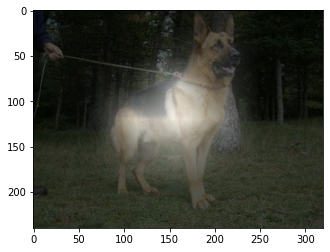

Original Bouding box


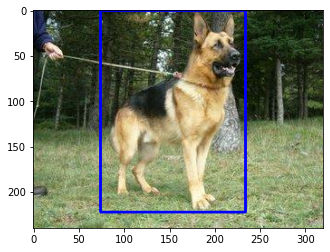

Predicted Bouding box


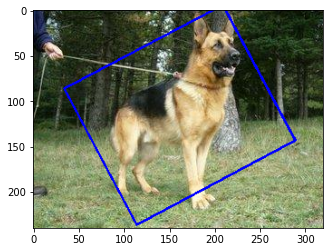

IoU : 0.5755955348851673 with score_thresh 0.05, act_layer_name conv5_block3_out


In [101]:
calculate_iou_and_visualize_bbox(cam_model, item, grad=True, act_layer_name='conv5_block3_out', debug=True)

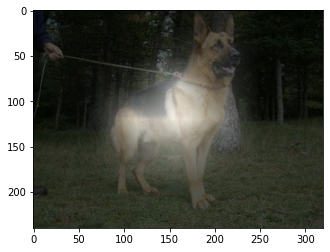

Original Bouding box


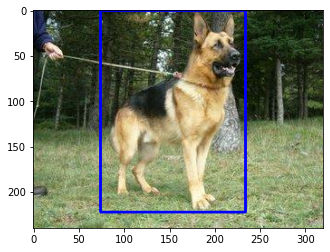

Predicted Bouding box


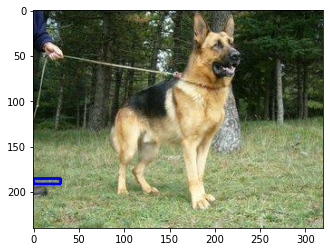

IoU : 0.0 with score_thresh 0.01, act_layer_name conv5_block3_out


In [102]:
calculate_iou_and_visualize_bbox(cam_model, item, grad=True, act_layer_name='conv5_block3_out', score_thresh=0.01, debug=True)

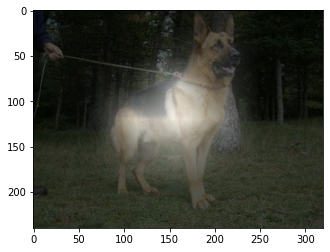

Original Bouding box


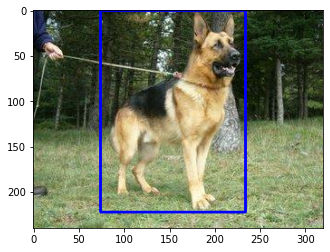

Predicted Bouding box


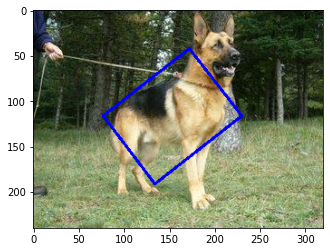

IoU : 0.6418074241611452 with score_thresh 0.3, act_layer_name conv5_block3_out


In [103]:
calculate_iou_and_visualize_bbox(cam_model, item, grad=True, act_layer_name='conv5_block3_out', score_thresh=0.3, debug=True)

| Threshold value | 0.01 | 0.05 | 0.3  |
|-----------------|------|------|------|
| CAM IoU         | 0.64 | 0.67 | 0.69 |
| Grad-CAM IoU    | 0    | 0.58 | 0.64 |

- CAM을 이용하여 bounding box를 추론하여 계산한 IoU는 대체로 높은 값이 나왔는데, 박스가 비교적 커서 그런 결과가 나온 것으로 생각
- 하지만 바운딩 박스를 그린 이미지를 비교해보면, CAM의 bbox는 의미없는 영역을 많이 포함
- threshold를 높이면 당연하게도 활성화 값이 적은 픽셀들은 제외가 되어 박스가 작아짐

---

### 그럼 추론 확률이 큰 n개의 클래스에 대해서는..?
[클릭 이동](./0304_cam_top_n_impl.ipynb)